# CS 109A/AC 209A/STAT 121A Data Science: Homework 4
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, October 5th, 2016 at 11:59pm

Import libraries

In [311]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import sklearn.preprocessing as Preprocessing
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Halperin, Keyan]

### Part (b): Course Number

[STATS 121a]

## Problem 1: Variable selection and regularization

The data set for this problem is provided in ``dataset_1.txt`` and contains 10 predictors and a response variable.

### Part (a): Analyze correlation among predictors
- By visually inspecting the data set, do find that some of the predictors are correlated amongst themselves?


- Compute the cofficient of correlation between each pair of predictors, and visualize the matrix of correlation coefficients using a heat map. Do the predictors fall naturally into groups based on the correlation values?


- If you were asked to select a minimal subset of predictors based on the correlation information in order to build a good regression model, how many predictors will you pick, and which ones will you choose? 

In [370]:
# Load data
data = np.loadtxt('dataset_1.txt', delimiter=',', skiprows=1)

# Split predictors and response
x = data[:, :-1]
y = data[:, -1]

df = pd.DataFrame(data)
df_x = df.iloc[:, :-1]
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.959357,0.959357,0.959357,0.343727,0.524083,0.537768,0.435598,0.831999,0.153247,0.005016,0.289394
1,0.616969,0.616969,0.616969,0.287376,0.513844,0.497775,0.452732,0.914609,0.367390,0.444473,-0.277574
2,0.995941,0.995941,0.995941,0.107294,0.097106,0.146751,0.136414,0.635926,0.535209,0.899457,-0.513097
3,0.821732,0.821732,0.821732,0.202558,0.329504,0.359471,0.281453,0.106263,0.479327,0.256271,-0.182353
4,0.302423,0.302423,0.302423,0.184564,0.270263,0.293385,0.263866,0.378630,0.740241,0.468589,-0.625117


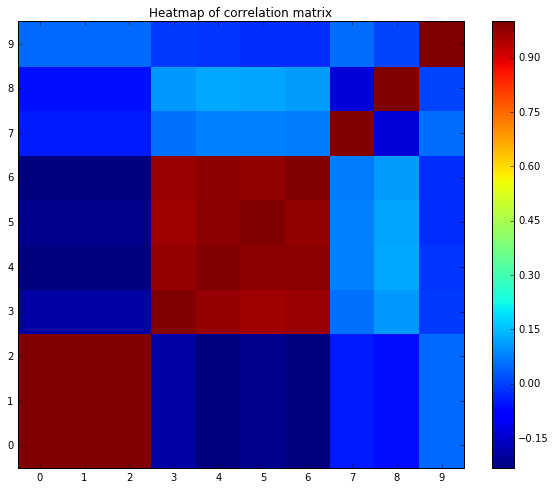

In [377]:
# Compute matrix of correlation coefficients
corr_matrix = np.corrcoef(df_x.T)

# visualize correlation matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
heat_map = ax.pcolor(corr_matrix)
ax.set_title('Heatmap of correlation matrix')
plt.colorbar(heat_map) #legend

# Set ticks in center of cells
ax.set_xticks(np.arange(corr_matrix.shape[1]) + 0.5, minor = False)
ax.set_yticks(np.arange(corr_matrix.shape[0]) + 0.5, minor = False)

# Change x and y labels 
names = df_x.columns
ax.set_xticklabels(names)
ax.set_yticklabels(names)

plt.show()

Based on looking at the head of the data and the heatmap of the correlation matrix, some of the predictors are strongly correlated with each other. This is especially true for the first 3 covariates because they are identical. Variables 3 through 6 are also highly correlated with each other. As a result, I would only select one of the first 3 variables, one of the variables from 3 through 6. Because they are explaining the same or similar things, including them in the model would be redundant and cause collinearity problems. However, since covariates 7 through 9 are not correlated with each other, I would include all of them.

### Part (b): Selecting minimal subset of predictors

- Apply the variable selection methods discussed in class to choose a minimal subset of predictors that yield high prediction accuracy:
    
    - Exhaustive search
    
    - Step-wise forward selection **or** Step-wise backward selection  

&emsp;&nbsp;&nbsp; In each method, use the Bayesian Information Criterion (BIC) to choose the subset size.

- Do the chosen subsets match the ones you picked using the correlation matrix you had visualized in Part (a)?

**Note**: You may use the `statsmodels`'s `OLS` module to fit a linear regression model and evaluate BIC. You may **not** use library functions that implement variable selection.

In [320]:
### Best Subset Selection
min_bic = 1e10 # set some initial large value for min BIC score
best_subset = [] # best subset of predictors

# Create all possible subsets of the set of 10 predictors
predictor_set = set(range(10)) # predictor set = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Repeat for every possible size of subset
for size_k in range(10): 
    # Create all possible subsets of size 'size', 
    # using the 'combination' function from the 'itertools' library
    subsets_of_size_k = it.combinations(predictor_set, size_k + 1) 
    
    max_r_squared = -1e10 # set some initial small value for max R^2 score
    best_k_subset = [] # best subset of predictors of size k
    
    # Iterate over all subsets of our predictor set
    for predictor_subset in subsets_of_size_k:    
        # Use only a subset of predictors in the training data
        x_subset = x[:, predictor_subset]

        # Fit and evaluate R^2
        x1_subset = sm.add_constant(x_subset)
        model = OLS(y, x1_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Update max R^2 and best predictor subset of size k
        # If current predictor subset has a higher R^2 score than that of the best subset 
        # we've found so far, remember the current predictor subset as the best!
        if(r_squared > max_r_squared): 
            max_r_squared = r_squared
            best_k_subset = predictor_subset[:]
                

    # Use only the best subset of size k for the predictors
    x_subset = x[:, best_k_subset]
        
    # Fit and evaluate BIC of the best subset of size k
    x1_subset = sm.add_constant(x_subset)
    model = OLS(y, x1_subset)
    results = model.fit()
    bic = results.bic
    
    # Update minimum BIC and best predictor subset
    # If current predictor has a lower BIC score than that of the best subset 
    # we've found so far, remember the current predictor as the best!
    if(bic < min_bic): 
        min_bic = bic
        best_subset = best_k_subset[:]
    
print('Best subset by exhaustive search:')
print sorted(best_subset)

Best subset by exhaustive search:
[0, 5, 7, 8, 9]


This matches the variables I selected based on the correlation matrix!

In [321]:
### Step-wise Forward Selection
d = x.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors, and the remaining set of predictors
current_predictors = [] 
remaining_predictors = range(d)

# Set some initial large value for min BIC score for all possible subsets
global_min_bic = 1e10 

# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, 0 predictors to d predictors
for size in range(d):    
    max_r_squared = -1e10 # set some initial small value for max R^2
    best_predictor = -1 # set some throwaway initial number for the best predictor to add
    bic_with_best_predictor = 1e10 # set some initial large value for BIC score   
        
    # Iterate over all remaining predictors to find best predictor to add
    for i in remaining_predictors:
        # Make copy of current set of predictors
        temp = current_predictors[:]
        # Add predictor 'i'
        temp.append(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = x[:, temp]
        
        # Fit and evaluate R^2
        x1_subset = sm.add_constant(x_subset)
        model = OLS(y, x1_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if(r_squared > max_r_squared):
            max_r_squared = r_squared
            best_predictor = i
            bic_with_best_predictor = results.bic
    
    # Remove best predictor from remaining list, and add best predictor to current list
    remaining_predictors.remove(best_predictor)
    current_predictors.append(best_predictor)
    
    # Check if BIC for with the predictor we just added is lower than 
    # the global minimum across all subset of predictors
    if(bic_with_best_predictor < global_min_bic):
        best_subset = current_predictors[:]
        global_min_bic = bic_with_best_predictor
    
print 'Step-wise forward subset selection:'
print sorted(best_subset) # add 1 as indices start from 0

Step-wise forward subset selection:
[0, 5, 7, 8, 9]


This matches the variables I selected based on the correlation matrix!

In [322]:
###  Step-wise Backward Selection
d = x.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors
current_predictors = range(d)

# First, fit and evaluate BIC using all 'd' number of predictors
x1 = sm.add_constant(x)
model = OLS(y, x1)
results = model.fit()
bic_all = results.bic

# Set the minimum BIC score, initially, to the BIC score using all 'd' predictors
global_min_bic = bic_all
# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, d predictors to 1 predictor
for size in range(d - 1, 1, -1): # stop before 0 to avoid choosing an empty set of predictors
    max_r_squared = -1e10 # set some initial small value for max R^2
    worst_predictor = -1 # set some throwaway initial number for the worst predictor to remove
    bic_without_worst_predictor = 1e10 # set some initial large value for min BIC score  
        
    # Iterate over current set of predictors (for potential elimination)
    for i in current_predictors:
        # Create copy of current predictors, and remove predictor 'i'
        temp = current_predictors[:]
        temp.remove(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = x[:, temp]
        
        # Fit and evaluate R^2
        x1_subset = sm.add_constant(x_subset)
        model = OLS(y, x1_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if(r_squared > max_r_squared):
            max_r_squared = r_squared
            worst_predictor = i
            bic_without_worst_predictor = results.bic
          
    # Remove worst predictor from current set of predictors
    current_predictors.remove(worst_predictor)
    
    # Check if BIC for the predictor we just removed is lower than 
    # the global minimum across all subset of predictors
    if(bic_without_worst_predictor < global_min_bic):
        best_subset = current_predictors[:]
        global_min_bic = bic_without_worst_predictor
    
print 'Step-wise backward subset selection:'
print sorted(best_subset)

Step-wise backward subset selection:
[2, 5, 7, 8, 9]


This matches the variables I selected based on the correlation matrix!

### Part (c): Apply Lasso and Ridge regression

- Apply Lasso regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

    - Identify the predictors that are assigned non-zero coefficients. Do these correspond to  the correlation matrix in Part (a)?


- Apply Ridge regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

    - Is there a difference between the model parameters you obtain different and those obtained from Lasso regression? If so, explain why.

    - Identify the predictors that are assigned non-zero coefficients. Do these correspond to  the correlation matrix in Part (a)?


- Is there anything peculiar that you observe about the coefficients Ridge regression assigns to the first three predictors? Do you observe the same with Lasso regression? Give an explanation for your observation.

**Note**: You may use the `statsmodels` or `sklearn` to perform Lasso and Ridge regression.

In [323]:
#We should always standardize before doing Lasso or Ridge
x_std = Preprocessing.scale(x, with_mean = False)

In [324]:
# Lasso regression
reg = Lasso_Reg(alpha = 0.01)
reg.fit(x_std, y)
coefficients = reg.coef_

print 'Lasso:'
print 'Coefficients:', coefficients
print  'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Lasso:
Coefficients: [ 0.02849182  0.          0.         -0.         -0.         -0.03684201
 -0.          0.04021157 -0.12494512 -0.09184856]
Predictors with non-zero coefficients: [0, 5, 7, 8, 9]


The predictors that are assigned non-zero coefficients match the variables I selected based on the correlation matrix!

In [325]:
# Ridge regression: Fit and evaluate 
reg = Ridge_Reg(alpha = 0.01)
reg.fit(x_std, y)
coefficients = reg.coef_

print 'Ridge:'
print 'Coefficients:', coefficients
print 'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Ridge:
Coefficients: [ 0.01202839  0.01202839  0.01202839  0.08215546 -0.05164384 -0.13888768
  0.06613925  0.05307179 -0.12990042 -0.10333556]
Predictors with non-zero coefficients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


There is a significant difference between the predictors and estimates that I obtained for Ridge and Lasso. While Lasso only selected 5 predictors, Ridge includes all of them because Ridge does not force any coefficients to be zero. As a result, the Ridge model includes variables that are redunant or unecessary. This is most clearly seen by the fact that the first 3 predictors are completely identical, but instead of choosing one of them, Ridge includes all of them, and since they are identical, they have the same coefficients. 

## Problem 2: Cross-validation and Bootstrapping
In this problem, you will work with an expanded version of the automobile pricing data set you analyzed in Homework 3. The data set is contained ``dataset_2.txt``, with 26 attribues (i.e. predictors) for each automobile and corresponding prices. 

### Part(a): Encode categorical attributes and fill missing values
Identify the categorical attributes in the data. Replace their values with the one-hot binary encoding. You may do this using the `get_dummies()` function in `pandas`. If you do this task correctly, you should get a total of 69 predictors after the encoding.


In [360]:
data = pd.read_csv('dataset_2.txt')
data.head()

,horsepower,highway-mpg,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,...,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,peak-rpm,city-mpg,price
0,95.0,24.0,0.0,120.232558,peugot,gas,std,four,wagon,rwd,...,l,four,120.0,mpfi,3.46,2.19,8.4,5000.0,19.0,16695.0
1,116.0,30.0,2.0,134.000000,toyota,gas,std,two,hardtop,rwd,...,ohc,four,146.0,mpfi,3.62,3.50,9.3,4800.0,24.0,11199.0
2,121.0,28.0,0.0,188.000000,bmw,gas,std,two,sedan,rwd,...,ohc,six,164.0,mpfi,3.31,3.19,9.0,4250.0,21.0,20970.0
3,184.0,16.0,0.0,120.232558,mercedes-benz,gas,std,four,sedan,rwd,...,ohcv,eight,308.0,mpfi,3.80,3.35,8.0,4500.0,14.0,40960.0
4,111.0,29.0,0.0,102.000000,subaru,gas,turbo,four,sedan,4wd,...,ohcf,four,108.0,mpfi,3.62,2.64,7.7,4800.0,24.0,11259.0


In [361]:
# Separate predictors and response
x_df = data.iloc[:,:-1]
y_df = data.iloc[:,-1]

d = np.shape(x_df)[1] 

# Create a new data frame with first attribute
x_df_expanded = pd.DataFrame({}) # first column is numerical

# Iterate over all attributes
for column in x_df.columns:
    # Check if attribute is not categorical: either dtype is not object
    if(x_df[column].dtype != np.dtype('object') and column != 'symboling'):
        x_df_expanded = pd.concat([x_df_expanded, x_df[column]], axis=1)
    else:
        # otherwise: use one-hot encoding
        encoding = pd.get_dummies(x_df[column]) 
        # append expanded attribute to data frame
        x_df_expanded = pd.concat([x_df_expanded, encoding], axis=1)

x_df_expanded.head()

,horsepower,highway-mpg,-2.0,0.0,1.0,1.09604519774,2.0,3.0,normalized-losses,audi,...,1bbl,2bbl,idi,mpfi,spdi,bore,stroke,compression-ratio,peak-rpm,city-mpg
0,95.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,120.232558,0.0,...,0.0,0.0,0.0,1.0,0.0,3.46,2.19,8.4,5000.0,19.0
1,116.0,30.0,0.0,0.0,0.0,0.0,1.0,0.0,134.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,3.62,3.50,9.3,4800.0,24.0
2,121.0,28.0,0.0,1.0,0.0,0.0,0.0,0.0,188.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,3.31,3.19,9.0,4250.0,21.0
3,184.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,120.232558,0.0,...,0.0,0.0,0.0,1.0,0.0,3.80,3.35,8.0,4500.0,14.0
4,111.0,29.0,0.0,1.0,0.0,0.0,0.0,0.0,102.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,3.62,2.64,7.7,4800.0,24.0


### Part (b): Apply regular linear regression
- Split the data set into train and test sets, with the first 25% of the data for training and the remaining for testing.  


- Use regular linear regression to fit a model to the training set and evaluate the R^2 score of the fitted model on both the training and test sets. What do you observe about these values?


- You had seen in class that the R^2 value of a least-squares fit to a data set would lie between 0 and 1. Is this true for the test R^2 values reported above? If not, give a reason for why this is the case.


- Is there a need for regularization while fitting a linear model to this data set?

**Note**: You may use the `statsmodels` or `sklearn` to fit a linear regression model and evaluate the fits.

In [362]:
# Convert data frame to array
x = x_df_expanded.values
y = y_df.values

# ii. SPLIT TRAIN AND TEST SETS
n = x.shape[0]
n_train = int(np.round(n*0.25))

# First 25% train, remaining test
x_train = x[:n_train,:]
y_train = y[:n_train]
x_test = x[n_train:,:]
y_test = y[n_train:]

print x_train.shape #p > n!!

(51L, 69L)


In [363]:
# First, let's do plain OLS
reg = Lin_Reg()
reg.fit(x_train, y_train)

train_r_sq_plain = reg.score(x_train, y_train)
test_r_sq_plain = reg.score(x_test, y_test)

print 'Plain Regression: R^2 score on training set', train_r_sq_plain
print 'Plain Regression: R^2 score on test set', round(test_r_sq_plain, 3)

Plain Regression: R^2 score on training set 1.0
Plain Regression: R^2 score on test set -5.975


Although the R-squared on the training set is fantastic, the R-squared on the test set is awful (R-sq = -5.975). Although R-squared should fall between 0 and 1 for a least-squares fit on the training data, this is not necessarily the case for R-squared on the test data. This is because R-squared measures how much better a model does compared to simply using the mean. However, if a model does worse than the mean, which it can for the test data, than R-squared will be negative.

One reason this model may be doing so poorly on the test data is due to the dimensionality of the data. Since for the training data, the number of predictors is greater than the number of observations, OLS will overfit the training data, giving us a perfect fit (i.e. R-sq = 1). Consequently, it may not do a very good job on the test data. As a result, there is certainly a need for regularization.

### Part (c): Apply Ridge regression

- Apply Ridge regression on the training set for different values of the regularization parameter $\lambda$ in the range $\{10^{-7}, 10^{-6}, \ldots, 10^7\}$. Evaluate the R^2 score for the models you obtain on both the train and test sets. Plot both values as a function of $\lambda$. 


- Explain the relationship between the regularization parameter and the training and test R^2 scores.


- How does the best test R^2 value obtained using Ridge regression compare with that of plain linear regression? Explain.

**Note**: You may use the `statsmodels` or `sklearn` to fit a ridge regression model and evaluate the fits.

In [364]:
#We should always standardize before doing Lasso or Ridge
x_std = Preprocessing.scale(x, with_mean = False)

# ii. SPLIT TRAIN AND TEST SETS
n = x_std.shape[0]
n_train = int(np.round(n*0.25))

# First 25% train, remaining test
x_train = x_std[:n_train,:]
y_train = y[:n_train]
x_test = x_std[n_train:,:]
y_test = y[n_train:]

In [367]:
def RidgeReg(x_train, x_test, y_train, y_test, lambda_min=-4, lambda_max=4, num_lambdas=1000):
   
    num_predictors = x_train.shape[1]
    lambdas = np.linspace(lambda_min,lambda_max, num_lambdas)

    train_r_sq = np.zeros(num_lambdas)
    test_r_sq = np.zeros(num_lambdas)
    coeff_a =np.zeros((num_lambdas, num_predictors))
       
    for ind, i in enumerate(lambdas):    
        # Fit ridge regression on train set
        reg = Ridge_Reg(alpha = 10**i)
        reg.fit(x_train, y_train)

        coeff_a[ind,:] = reg.coef_
        # Evaluate train & test performance
        train_r_sq[ind] = reg.score(x_train, y_train)
        test_r_sq[ind] = reg.score(x_test, y_test)
     
        ind = ind + 1
        
    return train_r_sq, test_r_sq, coeff_a, lambdas


def PlotCoeff(lambdas, coeff_a):
    plt.figure(figsize=(12,12))
    h=plt.semilogx(10**lambdas, coeff_a);
    plt.ylabel("Standarized Coefficients")
    plt.xlabel(r'Regularization parameter $\lambda$')
    plt.legend(h, data.columns[1:7].values)
    plt.show()
    
def PlotR2( lambdas, test_r_sq_plain, train_r_sq, test_r_sq, x_train, y_train):
    # Plot train an test R-squared as a function parameter value
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    ax.axhline(y = test_r_sq_plain, c='g', label = 'OLS Train', linewidth=3)
    ax.semilogx(10.0**lambdas, (train_r_sq), c='b', label='Ridge: Train', linewidth=3)
    ax.semilogx(10.0**lambdas, (test_r_sq), c='r', label='Ridge: Test', linewidth=3)

    ax.set_xlabel('Regularization parameter $\lambda$')
    ax.set_ylabel(r'$R^2$')

    ax.set_ylim((test_r_sq_plain-0.2, 1.2))
    ax.legend(loc = 'best')

    print 'Regression: max R^2 score on training set', max(train_r_sq)
    print 'Regression: max R^2 score on test set', max(test_r_sq)
    
    best_lambda = lambdas[np.argmax(test_r_sq)]
    reg = Lasso_Reg(alpha = best_lambda)
    reg.fit(x_train, y_train)
    coeff = reg.coef_

    print 'Lambda which maximizes Test R-squared:', 10**(best_lambda)
    plt.show()

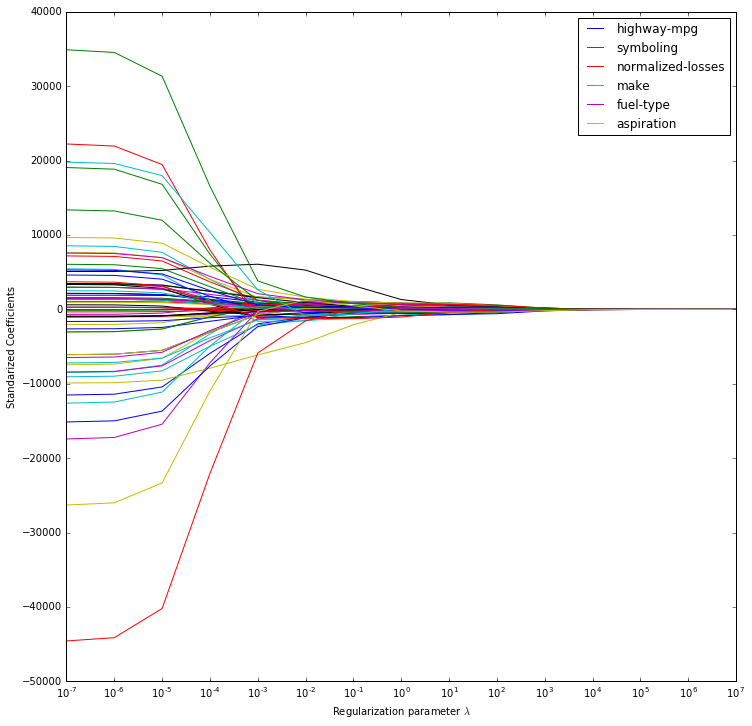

Regression: max R^2 score on training set 0.99999999965
Regression: max R^2 score on test set 0.944438790963
Lambda which maximizes Test R-squared: 1.0


C:\Users\Keyan\Anaconda2\lib\site-packages\ipykernel\__main__.py:52: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


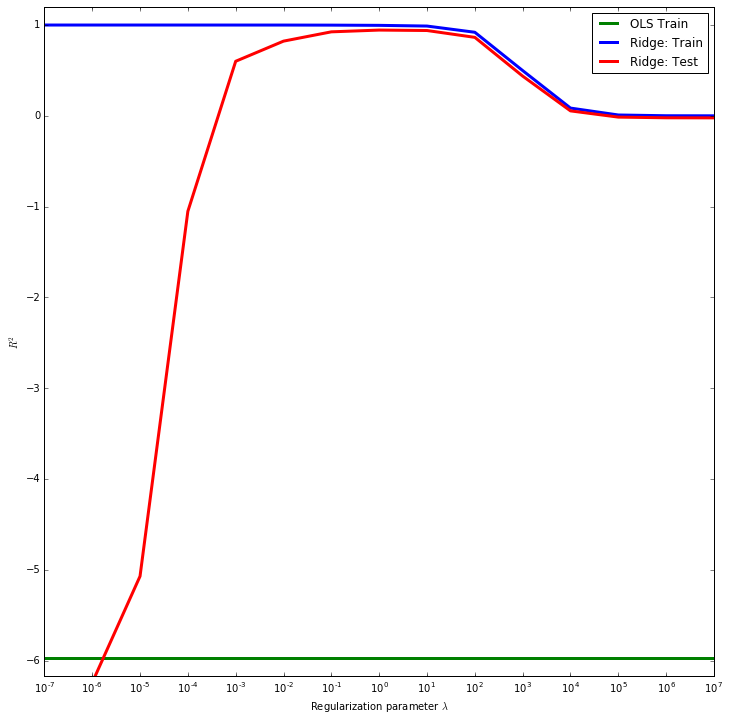

In [368]:
train_r_sq, test_r_sq, coeff_a, lambdas = RidgeReg(x_train, x_test, y_train, y_test, -7 ,7, 15)
PlotCoeff(lambdas, coeff_a)
PlotR2(lambdas, test_r_sq_plain, train_r_sq, test_r_sq, x_train, y_train)

As we can see above, for very small values of $\lambda$, the test R-sq is very low. This makes sense because when $\lambda = 0$, Ridge regression is equivalent to OLS. As $\lambda$ increases, the test R-sq increases as well until $\lambda = 1$, after which it starts to decrease. The best test R-sq is about .944, which is much much better than the R-sq from OLS (R-sq = -5.975).

The train R-sq on the other hand starts off really high, and continues to remain fairly high, until $\lambda = 100$, where it starts to decrease significantly. 

### Part (d): Tune regularization parameter using cross-validation and bootstrapping
-  Evaluate the performance of the Ridge regression for different regularization parameters $\lambda$ using 5-fold cross validation **or** bootstrapping on the training set. 

    - Plot the cross-validation (CV) or bootstrapping R^2 score as a function of $\lambda$. 
    
    - How closely does the CV score or bootstrapping score match the R^2 score on the test set? Does the model with lowest CV score or bootstrapping score correspond to the one with maximum R^2 on the test set?
    
    - Does the model chosen by CV or bootstrapping perform better than plain linear regression?

**Note**: You may use the `statsmodels` or `sklearn` to fit a linear regression model and evaluate the fits. You may also use `kFold` from `sklearn.cross_validation`. 

In [277]:
n = len(x_train)
lambda_list = range(-7, 8)
num_samples = 500
r_sq_list = [[-1]*num_samples for i in lambda_list]

for i in lambda_list:
    for j in range(num_samples):
        perm = np.random.randint(low=0, high=n, size=n)
        x_boot_train = x_train[perm] 
        y_boot_train = y_train[perm]
    
        reg = Ridge_Reg(alpha = 10**i)
        reg.fit(x_boot_train, y_boot_train)
        r_sq_list[i][j] = reg.score(x_test, y_test)

r_sq_mean = []       
for i in lambda_list:
    r_sq_mean.append(np.mean(r_sq_list[i]))
    
best_lambda = lambda_list[np.argmax(r_sq_mean)]
print 'Lambda which maximizes Test R-squared:', 10**(best_lambda)
print 'Best Test R-squared:', round(max(r_sq_mean), 3)

Lambda which maximizes Test R-squared: 1
Best Test R-squared: 0.802


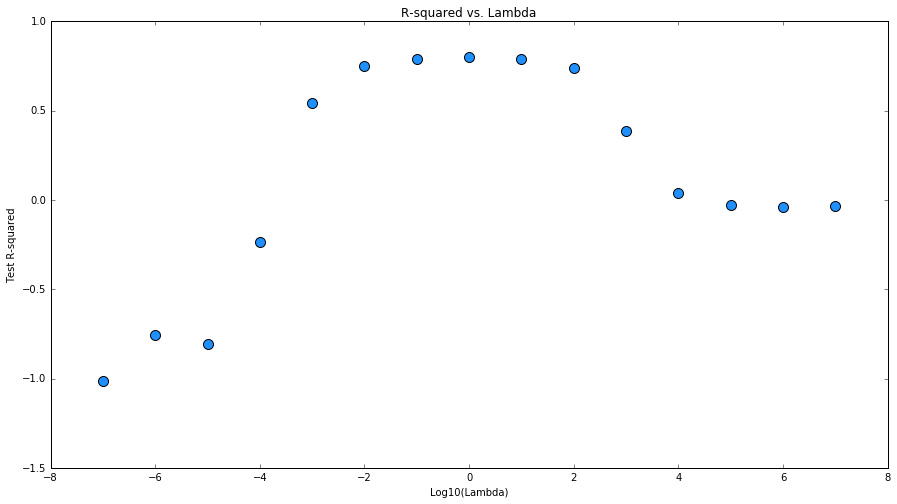

In [310]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 8))

testr = ax1.scatter(lambda_list, r_sq_mean, s=100, c='dodgerblue')

ax1.set_title('R-squared vs. Lambda') 
ax1.set_xlabel('Log10(Lambda)')
ax1.set_ylabel('Test R-squared')
plt.show()

The model chosen by bootstrapping performs significantly better than OLS, with a mean R-squared of about .8 compared to about -6 on the test data. The lambda which maximizes the mean R-squared is 1, which is the same lambda that we found from the previous problem. The R-squared is noticably lower than the one we got from the previous problem (.94), but they are somewhat similar.

## Problem 3: Ridge regression *via* ordinary least-squares regression

We present an approach to implement Ridge regression using oridinary least-squares regression. Given a matrix of responses $\mathbf{X} \in \mathbb{R}^{n\times p}$ and response vector $\mathbf{y} \in \mathbb{R}^{n}$, one can implement Ridge regression with regularization parameter $\lambda$ as follows:

- Augment the matrix of predictors $\mathbf{X}$ with $p$ new rows containing the scaled identity matrix $\sqrt{\lambda}\mathbf{I} \in \mathbb{R}^{p \times p}$, i.e.
$$\overline{\mathbf{X}} \,=\, 
\begin{bmatrix}
X_{11} & \ldots & X_{1p}\\
\vdots & \ddots & \vdots\\
X_{n1} & \ldots & X_{np}\\
\sqrt{\lambda} & \ldots & 0\\
\vdots & \ddots & \vdots\\
0 & \ldots & \sqrt{\lambda}
\end{bmatrix}
\,\in\,
\mathbb{R}^{(n+p)\times p}
.
$$


- Augment the response vector $\mathbf{y}$ with a column of $p$ zeros, i.e.
$$
\overline{\mathbf{y}} \,=\, 
\begin{bmatrix}
y_{1}\\
\vdots\\
y_{n}\\
0\\
\vdots\\
0
\end{bmatrix}
\,\in\,
\mathbb{R}^{n+p}.
$$


- Apply ordinary least-squares regression on the augmented data set $(\overline{\mathbf{X}}, \overline{\mathbf{y}})$.

### Part (a): Show the proposed approach implements Ridge regression
Show that the approach proposed above implements Ridge regression with parameter $\lambda$.

In Ridge regression the solution for the coefficients is $(\mathbf{X}^T \mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T \mathbf{y}$. It is clear that $(\overline{\mathbf{X}}^T \overline{\mathbf{X}})$ is equal to $(\mathbf{X}^T \mathbf{X} + \lambda \mathbf{I})$ by inspection. Since they are the same, they also have the same inverse. Also, $(\overline{\mathbf{X}}^T \overline{\mathbf{X}})^{-1}\overline{\mathbf{X}}^T$ will be a $p$ x $(n + p)$ matrix where the first $n$ columns are equivalent to the $(\mathbf{X}^T \mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T$ matrix. Since $\overline{\mathbf{y}}$ has $p$ zeros appended to the bottom of it, and the final $p$ columns in $(\overline{\mathbf{X}}^T \overline{\mathbf{X}})^{-1}\overline{\mathbf{X}}^T$ are not in $(\mathbf{X}^T \mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T$, $(\overline{\mathbf{X}}^T \overline{\mathbf{X}})^{-1}\overline{\mathbf{X}}^T \overline{\mathbf{y}}$ will be equal to $(\mathbf{X}^T \mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T \mathbf{y}$ as required.

### Part (b): Debug our implementation of ridge regression
You're a grader for CS109A, the following is an implemention of Ridge regression (via the above approach) submitted by a student. The dataset is ``dataset_3.txt``. The regression model is fitted to a training set, and the R^2 scores of the fitted model on the training and test sets are plotted as a function of the regularization parameter. Grade this solution according to the following rubric (each category is equally weighted): 

- correctness

- interpretation (if applicable)

- code/algorithm design

- presentation

In addition to providing an holistic grade (between 0 to 5), provide a corrected version of this code that is submission quality.

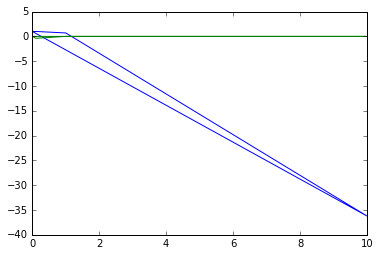

In [351]:
# Fit
def ridge(x_train, y_train, reg_param):
    n=np.shape(x_train)[0]
    x_train=np.concatenate((x_train,reg_param*np.identity(n)),axis=1)
    y_train_=np.zeros((n+np.shape(x_train)[1],1))
    for c in range(n):
        y_train_[c]= y_train[c]
    import sklearn
    model = sklearn.linear_model.LinearRegression()
    model.fit(x_train,y_train.reshape(-1,1))
    return model

# Score
def score(m,x_test,y_test, reg_param):
    n=np.shape(x_train)[0]
    x_test=np.concatenate((x_test,reg_param*np.identity(n)),axis=1)
    y_test_=np.zeros((n+np.shape(x_test)[1],1))
    for c in range(n):
        y_test_[c]= y_test[c]
    return m.score(x_test,y_test.reshape(-1,1))

# Load
data = np.loadtxt('datasets/dataset_3.txt', delimiter=',')
n = data.shape[0]
n = int(np.round(n*0.5))
x_train = data[0:n,0:100]
y_train = data[0:n,100]
x_test = data[n:2*n,0:100]
y_test = data[n:2*n,100]

# Params
a=np.zeros(5)
for i in range(-2,2):
    a[i+2]=10**i

# Iterate
rstr =np.zeros(5)
rsts =np.zeros(5)
for j in range(0,5):    
    m =ridge(x_train,y_train,a[i])
    rstr[j]=score(m,x_train,y_train,a[j])
    rsts[i]=score(m,x_test,y_test,a[i])

# Plot
plt.plot(a,rstr)
plt.plot(a,rsts)

Although this student definitely had the right the idea, there is a significant number of mistakes, and so I would only give them .5/1.25 for correctness. There is quite literally no interpretation or explanation of any kind, even though it is defintiely needed. 0/1.25 for interpretation. Likewise, there needs to be more descriptive comments in the code, and variables should given descriptive names. But other than that, the code in and of itself is not too bad. .75/1.25 for code/algorithm design. Presentation is very poor as well. Although there is a plot, it has no title, labels, and it is not entirely clear what the student is trying to demonstrate. .25/1.25 for presentation. 

So overall, I would give this student a 1.5/5. For more specifics as to the particular mistakes and places where the student could improve, see the annoted, corrected version of the code below. 

R-squared Train Values: [ 0.99722008  0.9933472   0.99001533  0.96975735  0.7934162 ]
R-squared Test Values: [-13.95668561  -0.74036817   0.50457854   0.69233251   0.50475606]


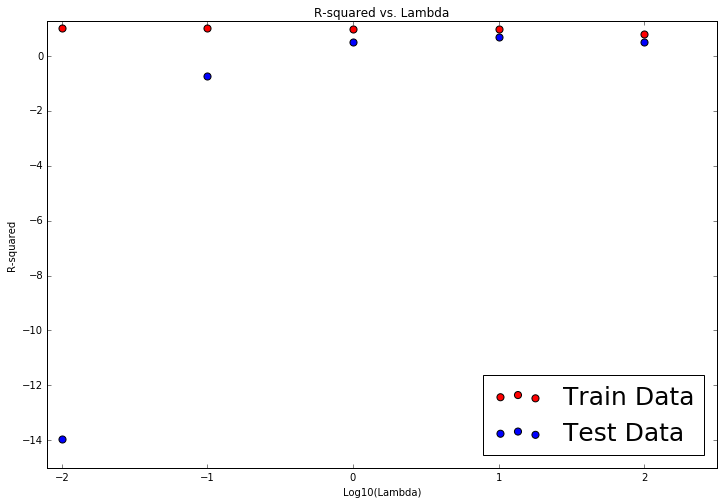

In [352]:
def ridge(x_train, y_train, reg_param):
    
    #Be sure to keep track of your dimensions!
    n = np.shape(x_train)[0] #number of observations
    p = np.shape(x_train)[1] #number of predictors
    
    #Identity matrix is of dimension p x p
    lam_id = reg_param**(1/2.0)*np.identity(p) #don't forget to take the square root of lambda                              
    x_train_new = np.concatenate((x_train, lam_id), axis=0) #axis=0 appends new matrix to the bottom
    
    p_zeros = np.zeros(p)
    y_train_new = np.concatenate((y_train, p_zeros), axis=0)

    import sklearn
    model = sklearn.linear_model.LinearRegression()
    model.fit(x_train_new, y_train_new)
    return model

#Once you create your model, you don't need to do anything fancy to evaluate your model. 
#Just use the built-in score function
def score(m, x, y):

    return m.score(x, y)

# Load Data
data = np.loadtxt('datasets/dataset_3.txt', delimiter=',')
data_x = data[:, :100] #select all columns except the last one

#We should always standardize before doing Ridge
data_x_std = Preprocessing.scale(data_x, with_mean = False)

n = data.shape[0]
n = int(np.round(n*0.5))

x_train = data_x_std[:n, :]
y_train = data[:n, 100]

x_test = data_x_std[n:, :]
y_test = data[n:, 100]

a = np.zeros(5)
log_lambda = range(-2,3) #range(x, y) is up to, but not including y

for i in log_lambda:  
    a[i+2]=10**i

R_sq_train = np.zeros(5)  #Be sure to give your variables clear, unambiguous names
R_sq_test = np.zeros(5)

#Be sure to be consistent with regard to the variable you are iterating
for j in range(5):    
    m = ridge(x_train, y_train, a[j])
    R_sq_train[j] = score(m, x_train, y_train) 
    R_sq_test[j] = score(m, x_test, y_test)

print 'R-squared Train Values:', R_sq_train
print 'R-squared Test Values:', R_sq_test

#Be sure to label your plot, axes, and make it clear what you are trying to demonstrate
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
trainr = plt.scatter(log_lambda, R_sq_train, s=50, c='r')
testr = plt.scatter(log_lambda, R_sq_test, s=50, c='b')
ax1.legend((trainr, testr), ("Train Data", "Test Data"), prop={'size':25}, loc=4)
ax1.set_title('R-squared vs. Lambda') 
ax1.set_xlabel('Log10(Lambda)')
ax1.set_ylabel('R-squared')
ax1.set_ylim(-15, 1.25)
ax1.set_xlim(-2.1,2.5)
plt.show()